In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import warnings
from sklearn.exceptions import ConvergenceWarning

In [22]:
# Ignore warnings for clean output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [23]:
# Load the dataset
data = pd.read_csv('nba.csv')

# Inspect the dataset
print(data.head())  # View first few rows
print(data.info())  # Check data types and missing values
print(data['TAR'].value_counts())  # Check target class distribution (class imbalance check)

              Name  GP   MIN  PPT  FGM  FGA   FG%  3PM  3PA   3P%  ...  FTA  \
0   Brandon Ingram  36  27.4  7.4  2.6  7.6  34.7  0.5  2.1  25.0  ...  2.3   
1  Andrew Harrison  35  26.9  7.2  2.0  6.7  29.6  0.7  2.8  23.5  ...  3.4   
2   JaKarr Sampson  74  15.3  5.2  2.0  4.7  42.2  0.4  1.7  24.4  ...  1.3   
3      Malik Sealy  58  11.6  5.7  2.3  5.5  42.6  0.1  0.5  22.6  ...  1.3   
4      Matt Geiger  48  11.5  4.5  1.6  3.0  52.4  0.0  0.1   0.0  ...  1.9   

    FT%  OREB  DREB  REB  AST  STL  BLK  TOV  TAR  
0  69.9   0.7   3.4  4.1  1.9  0.4  0.4  1.3    0  
1  76.5   0.5   2.0  2.4  3.7  1.1  0.5  1.6    0  
2  67.0   0.5   1.7  2.2  1.0  0.5  0.3  1.0    0  
3  68.9   1.0   0.9  1.9  0.8  0.6  0.1  1.0    1  
4  67.4   1.0   1.5  2.5  0.3  0.3  0.4  0.8    1  

[5 rows x 21 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name

In [24]:
# Drop the 'Name' column as it is not useful for classification
data = data.drop(columns=['Name'])

In [25]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

GP       0
MIN      0
PPT      0
FGM      0
FGA      0
FG%      0
3PM      0
3PA      0
3P%     11
FTM      0
FTA      0
FT%      0
OREB     0
DREB     0
REB      0
AST      0
STL      0
BLK      0
TOV      0
TAR      0
dtype: int64


In [26]:
# Drop rows with missing values to ensure model integrity
# Alternative: We could use imputation, but dropping is simpler if missing values are minimal
data = data.dropna()

# Feature Engineering: Create a new feature "Efficiency"
# This metric considers offensive and defensive contributions while penalizing inefficiency
# Avoid division by zero using 1e-9

data['Efficiency'] = (data['FGM'] + data['REB'] + data['AST'] + data['STL'] + data['BLK']) / (data['FGA'] + data['TOV'] + 1e-9)

In [27]:
# Normalize numerical features using StandardScaler
# StandardScaler ensures features have zero mean and unit variance, improving model performance
scaler = StandardScaler()
numerical_features = data.drop(columns=['TAR']).columns
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Train-Test Split (80% training, 20% testing)
X = data.drop(columns=['TAR'])
y = data['TAR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

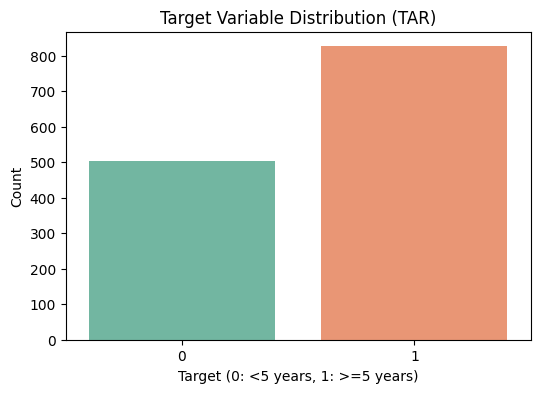

In [28]:
# Data Visualization: Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='TAR', data=data, palette='Set2')
plt.title('Target Variable Distribution (TAR)')
plt.xlabel('Target (0: <5 years, 1: >=5 years)')
plt.ylabel('Count')
plt.show()

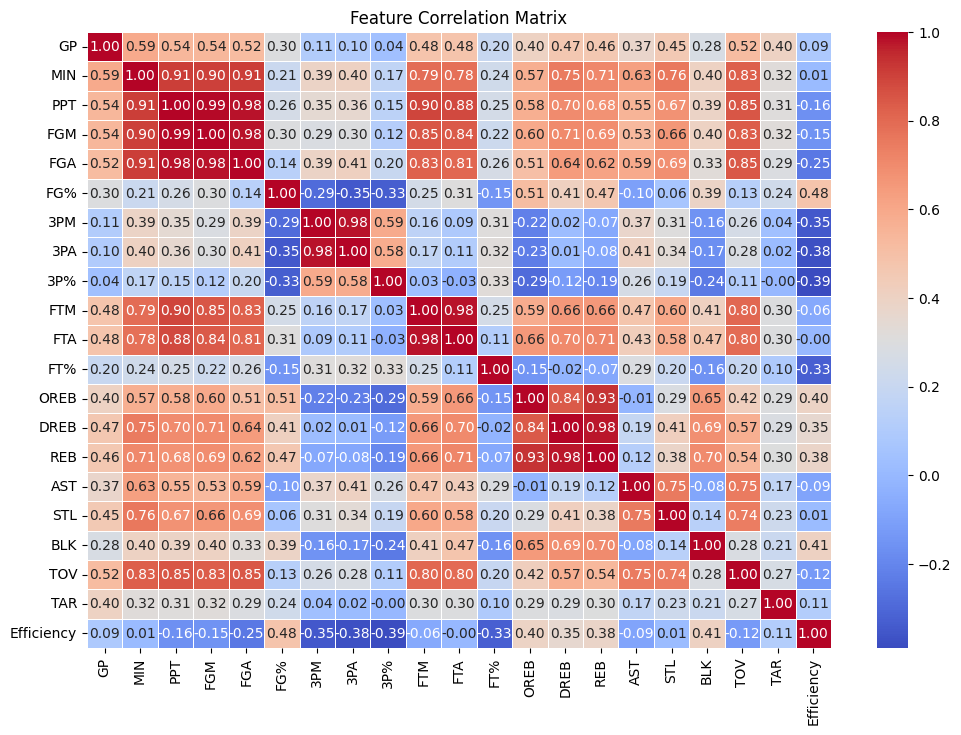

In [29]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [30]:
# K-Nearest Neighbors Classifier with GridSearchCV
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='f1')
grid_search.fit(X_train, y_train)
y_pred_knn = grid_search.predict(X_test)
print("Best KNN Parameters:", grid_search.best_params_)
print("KNN F1 Score:", f1_score(y_test, y_pred_knn))

Best KNN Parameters: {'n_neighbors': 11}
KNN F1 Score: 0.8171428571428572


In [31]:

# Random Forest Classifier with GridSearchCV
rf = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='f1')
grid_search.fit(X_train, y_train)
y_pred_rf = grid_search.predict(X_test)
print("Best RF Parameters:", grid_search.best_params_)
print("RF F1 Score:", f1_score(y_test, y_pred_rf))

Best RF Parameters: {'max_depth': 20, 'n_estimators': 200}
RF F1 Score: 0.8169014084507042


In [32]:
# Logistic Regression with GridSearchCV
log_reg = LogisticRegression(solver='saga', max_iter=1000, random_state=42)
param_grid = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(log_reg, param_grid, cv=10, scoring='f1')
grid_search.fit(X_train, y_train)
y_pred_lr = grid_search.predict(X_test)
print("Best Logistic Regression Parameters:", grid_search.best_params_)
print("Logistic Regression F1 Score:", f1_score(y_test, y_pred_lr))

Best Logistic Regression Parameters: {'C': 0.1, 'penalty': 'l1'}
Logistic Regression F1 Score: 0.8146067415730337


In [33]:
# Artificial Neural Network (MLP Classifier) with GridSearchCV
ann = MLPClassifier(random_state=42)
param_grid = {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['relu', 'tanh']}
grid_search = GridSearchCV(ann, param_grid, cv=10, scoring='f1')
grid_search.fit(X_train, y_train)
y_pred_ann = grid_search.predict(X_test)
print("Best ANN Parameters:", grid_search.best_params_)
print("ANN F1 Score:", f1_score(y_test, y_pred_ann))

Best ANN Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100,)}
ANN F1 Score: 0.7900552486187845


In [34]:
# Compare Models Based on F1 Score
f1_scores = {
    "KNN": f1_score(y_test, y_pred_knn),
    "Random Forest": f1_score(y_test, y_pred_rf),
    "Logistic Regression": f1_score(y_test, y_pred_lr),
    "Artificial Neural Network": f1_score(y_test, y_pred_ann)
}
# Select Best Model
best_model_name = max(f1_scores, key=f1_scores.get)
best_f1_score = f1_scores[best_model_name]
print(f"Best Model: {best_model_name} with F1 Score: {best_f1_score}")

# Ensure the best model's predictions are used for evaluation
y_pred_best = {
    "KNN": y_pred_knn,
    "Random Forest": y_pred_rf,
    "Logistic Regression": y_pred_lr,
    "Artificial Neural Network": y_pred_ann
}[best_model_name]


Best Model: KNN with F1 Score: 0.8171428571428572


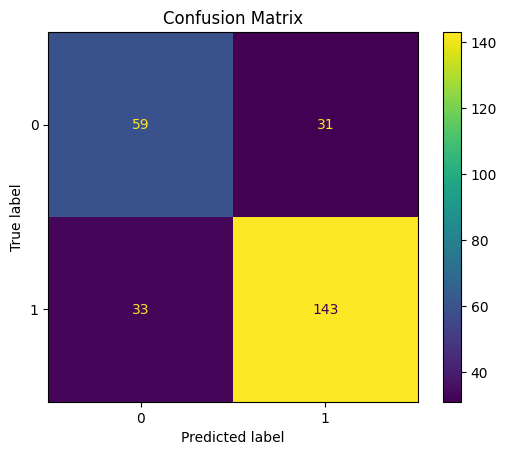

In [35]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

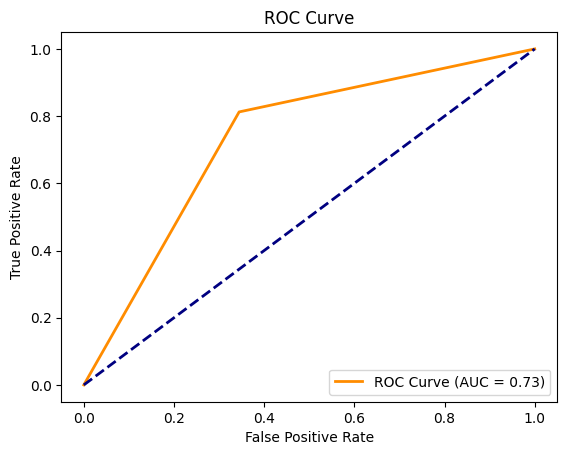

In [36]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_best)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()